## Xray Lung Classifier 

In [1]:
# Import the necessary libaries 
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

In [11]:
os.chdir("../")

In [12]:
pwd

'/home/jvdboss/workspace/ML_DL/image_classification/Lung_Xray_Classifier'

In [13]:
ls

build/    env/           pyproject.toml        research/  template.py
configs/  init_setup.sh  README.md             setup.cfg  tests/
dist/     LICENSE        requirements_dev.txt  setup.py   tox.ini
dvc.yaml  params.yaml    requirements.txt      src/


In [16]:
data_path = '../chest_xray'

In [17]:
class_name = ['NORMAL','PNEUMONIA']
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list
files_list_normal_train = get_list_files(data_path+'/train/'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'/train/'+class_name[1])
files_list_normal_test = get_list_files(data_path+'/test/'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'/test/'+class_name[1])

In [18]:
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneu_train)))
print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneu_test)))

Number of train samples in Normal category 558
Number of train samples in Pneumonia category 576
Number of test samples in Normal category 144
Number of test samples in Pneumonia category 252


In [19]:
rand_img_no = np.random.randint(0,len(files_list_normal_train))
img = data_path + '/train/NORMAL/'+ files_list_normal_train[rand_img_no]
# print(plt.imread(img).shape)
# #display(Image.open(img,'r'),)
# img = mpimg.imread(img)
# imgplot = plt.imshow(img)
# plt.show()

In [20]:
img = data_path + '/train/PNEUMONIA/'+ files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
# print(plt.imread(img).shape)
# img = mpimg.imread(img)
# imgplot = plt.imshow(img)
# plt.show()

In [21]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])])
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform= test_transform)
train_loader = DataLoader(train_data,
                          batch_size= 2, shuffle= True, pin_memory= True)
test_loader = DataLoader(test_data,
                         batch_size= 2, shuffle= False, pin_memory= True)
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 1134
Number of test images: 396


In [22]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         # Input Block
#         self.convblock1 = nn.Sequential(
#             nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3),
#                       padding=0, bias=False),
#             nn.ReLU(),
#             #nn.BatchNorm2d(4)
#         )
#         self.pool11 = nn.MaxPool2d(2, 2)
#         # CONVOLUTION BLOCK
#         self.convblock2 = nn.Sequential(
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
#                       padding=0, bias=False),
#             nn.ReLU(),
#             #nn.BatchNorm2d(16)
#         )
#         # TRANSITION BLOCK
#         self.pool22 = nn.MaxPool2d(2, 2)
#         self.convblock3 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#             #nn.BatchNorm2d(10),
#             nn.ReLU()
#         )
#         self.pool33 = nn.MaxPool2d(2, 2)
#         # CONVOLUTION BLOCK
#         self.convblock4 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             #nn.BatchNorm2d(10)
#         )
#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
#             #nn.BatchNorm2d(32),
#             nn.ReLU(),
#         )
#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#             nn.ReLU(),
#             #nn.BatchNorm2d(10),
#         )
#         self.convblock7 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             #nn.BatchNorm2d(10)
#         )
#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
#             #nn.BatchNorm2d(32),
#             nn.ReLU()
#         )
#         self.convblock9 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#             nn.ReLU(),
#             #nn.BatchNorm2d(10),
#         )
#         self.convblock10 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             #nn.BatchNorm2d(14),
#         )
#         self.convblock11 = nn.Sequential(
#             nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             #nn.BatchNorm2d(16),
#         )
#         # OUTPUT BLOCK
#         self.gap = nn.Sequential(
#             nn.AvgPool2d(kernel_size=4)
#         )
#         self.convblockout = nn.Sequential(
#               nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),
#         )
#     def forward(self, x):
#         x = self.convblock1(x)
#         x = self.pool11(x)
#         x = self.convblock2(x)
#         x = self.pool22(x)
#         x = self.convblock3(x)
#         x = self.pool33(x)
#         x = self.convblock4(x)
#         x = self.convblock5(x)
#         x = self.convblock6(x)
#         x = self.convblock7(x)
#         x = self.convblock8(x)
#         x = self.convblock9(x)
#         x = self.convblock10(x)
#         x = self.convblock11(x)
#         x = self.gap(x)
#         x = self.convblockout(x)
#         x = x.view(-1, 2)
#         return F.log_softmax(x, dim=-1)

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.pool11 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.pool22 = nn.MaxPool2d(2, 2)
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
        )
        self.pool33 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        )
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convblockout = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),
        )
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

In [24]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

Available processor cpu
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       216
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  16
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-4                       1,152
|    └─ReLU: 2-5                         --
|    └─BatchNorm2d: 2-6                  32
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-7                       160
|    └─ReLU: 2-8                         --
|    └─BatchNorm2d: 2-9                  20
├─MaxPool2d: 1-6                         --
├─Sequential: 1-7                        --
|    └─Conv2d: 2-10                      900
|    └─ReLU: 2-11                        --
|    └─BatchNorm2d: 2-12                 20
├─Sequential: 1-8                        --
|    └─Conv2d: 2-13                      

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       216
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  16
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-4                       1,152
|    └─ReLU: 2-5                         --
|    └─BatchNorm2d: 2-6                  32
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-7                       160
|    └─ReLU: 2-8                         --
|    └─BatchNorm2d: 2-9                  20
├─MaxPool2d: 1-6                         --
├─Sequential: 1-7                        --
|    └─Conv2d: 2-10                      900
|    └─ReLU: 2-11                        --
|    └─BatchNorm2d: 2-12                 20
├─Sequential: 1-8                        --
|    └─Conv2d: 2-13                      320
|    └─ReLU: 2-14   

In [25]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get data
        data, target = data.to(device), target.to(device)
        # Initialization of gradient
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and even though thats used in RNN generally not used in CNN
        # or specific requirements
        ## prediction on data
        y_pred = model(data)
        # Calculating loss given the prediction
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        # Backprop
        loss.backward()
        optimizer.step()
        # get the index of the log-probability corresponding to the max value
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [26]:
model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 2
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


Loss=1.0998626947402954 Batch_id=566 Accuracy=85.45: 100%|██████████| 567/567 [00:42<00:00, 13.33it/s]    


current Learning Rate:  0.01


Text(0.5, 1.0, 'Test Accuracy')

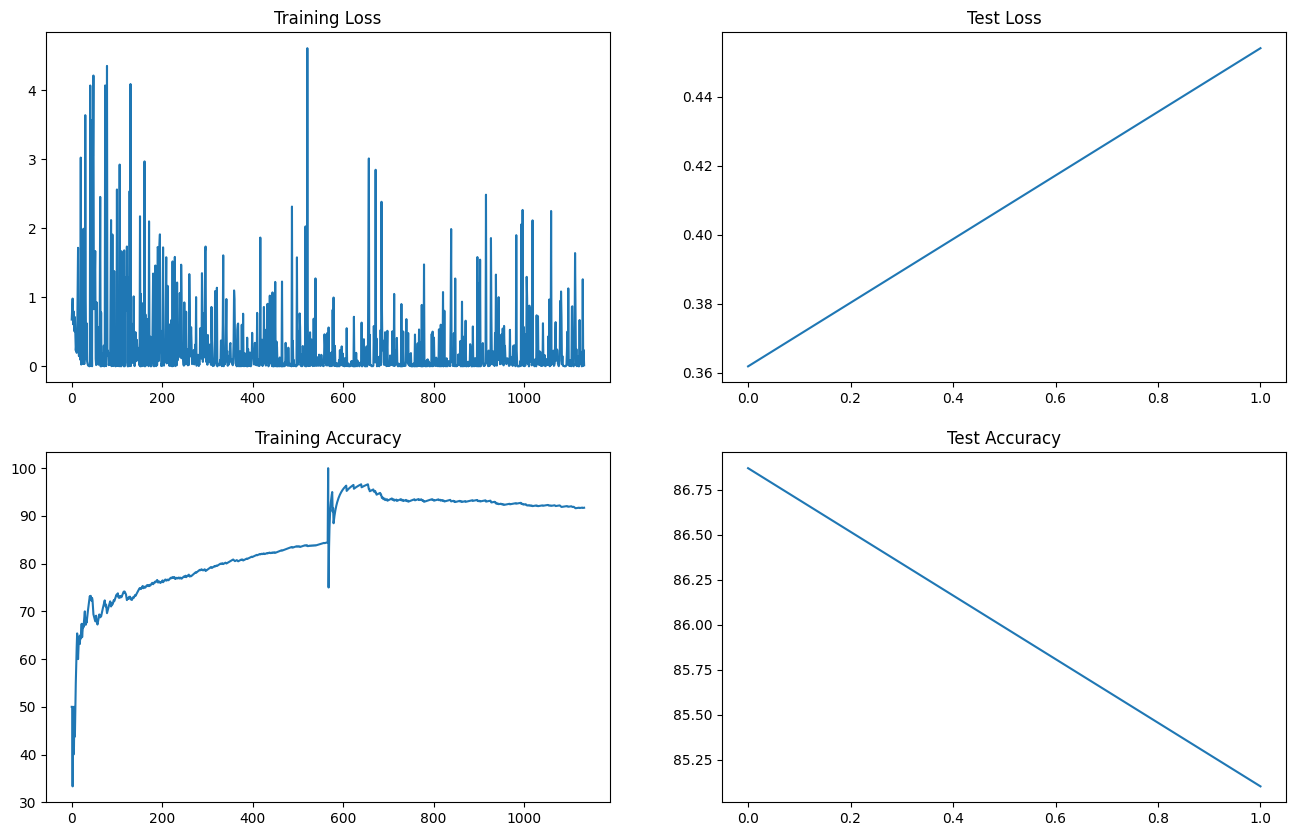

In [ ]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")


In [ ]:
print(test_losses)

[0.3617973851558583, 0.45404901709568524]
